In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import xgboost as xgb
from sklearn.metrics import classification_report

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, cross_validate


In [2]:
## Run this cell only once

# Create a new experiment
experiment_id = mlflow.create_experiment(
        name="loan_approval_predictions",
        artifact_location="loan_approval_predictions_artifacts",
        tags={"env": "dev", "version": "1.0.0"},
    )

print(experiment_id)    


839091360645189357


In [3]:
# Retrive experiment id using experiment name to reuse it

#experiment_id = mlflow.set_experiment("loan_approval_predictions").experiment_id

In [4]:
#Read data
df = pd.read_csv("artifacts\data\loan_data.csv")

#Investigate data
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


**person_age**	Age of the person	

**person_gender**	Gender of the person	

**person_education**	Highest education level	

**person_income**	Annual income	

**person_emp_exp**	Years of employment experience	

**person_home_ownership**	Home ownership status (e.g., rent, own, mortgage)	

**loan_amnt**	Loan amount requested	

**loan_intent**	Purpose of the loan	

**loan_int_rate**	Loan interest rate	

**loan_percent_income**	Loan amount as a percentage of annual income	

**cb_person_cred_hist_length**	Length of credit history in years	

**credit_score**	Credit score of the person	

**previous_loan_defaults_on_file**	Indicator of previous loan defaults	

**loan_status (target variable)**	Loan approval status: 1 = approved; 0 = rejected

In [5]:
#Data exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

 we can see that we don't have any missing values or null values.
 
 We have to convert integers into floats, so ML algorithms process them better.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00
loan_status,45000.0,0.222222,0.415744,0.00,0.00,0.00,0.00,1.00


 There are wrong values in [Person_age], the maximum value is 144! we are not dinasours, so we have to check for outliers in [Person_age] column.

 There are wrong values in [person_emp_exp], the maximum value is 125! so we have to check for outliers in [person_emp_exp] column.

 There could be outliers in [person_income], [loan_amnt], [cb_person_cred_hist_length].

 [loan_percent_income] repeate 2 information, [loan_amnt] and [person_income], so we can look for removing one of these to reveale correlation.

 we have to check for any correlation between the target variable [loan_status] and [[credit_score],[previous_loan_defaults_on_file], [loan_int_rate]]

First Remove wrong valeus from [person_age] and [person_emp_exp] columns
    1. show boxplot for each column to decide the border.
    2. remove values greater than border value.


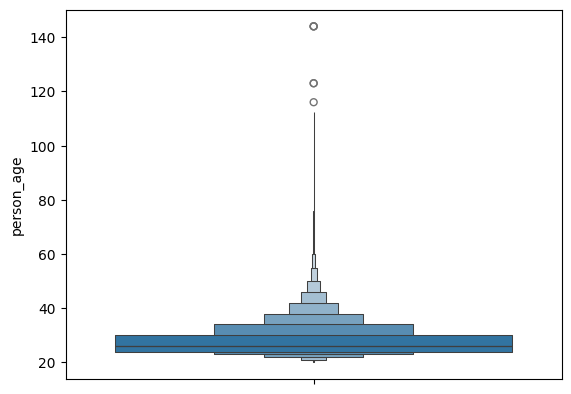

In [7]:
sns.boxenplot(data=df, y='person_age')
plt.show()

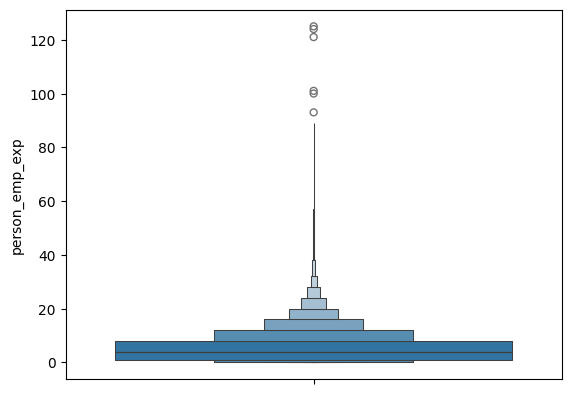

In [8]:
sns.boxenplot(data=df, y='person_emp_exp')
plt.show()

In [9]:
# Remove wrong valeus from [person_age] and [person_emp_exp] columns

df = df[(df["person_age"] < 80)]
df = df[(df["person_emp_exp"] < 60)]

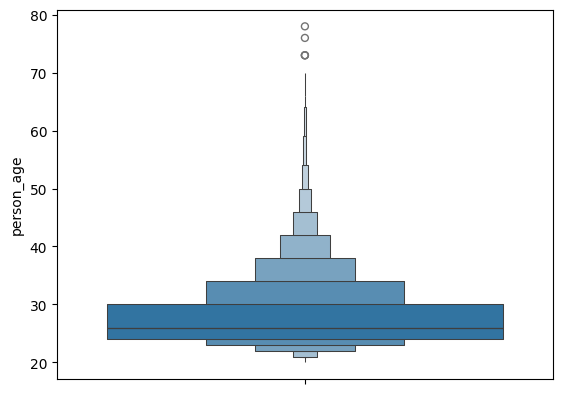

In [10]:
sns.boxenplot(data=df, y='person_age')
plt.show()

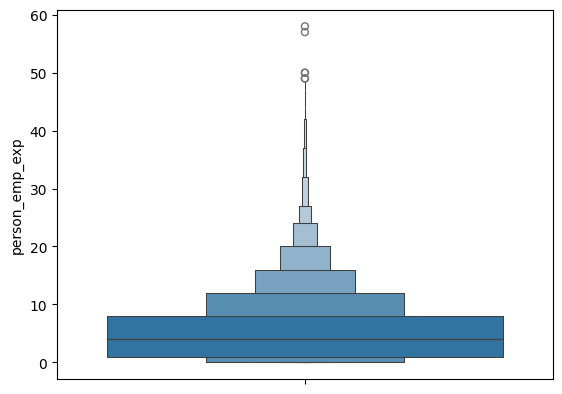

In [11]:
sns.boxenplot(data=df, y='person_emp_exp')
plt.show()

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,44990.0,27.744543,5.890563,20.00,24.00,26.00,30.00,78.00
person_income,44990.0,79908.834074,63323.588584,8000.00,47195.75,67045.50,95777.00,2448661.00
person_emp_exp,44990.0,5.390465,5.906165,0.00,1.00,4.00,8.00,58.00
loan_amnt,44990.0,9583.297888,6314.982527,500.00,5000.00,8000.00,12237.75,35000.00
loan_int_rate,44990.0,11.006510,2.979037,5.42,8.59,11.01,12.99,20.00
loan_percent_income,44990.0,0.139737,0.087208,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,44990.0,5.865259,3.874023,2.00,3.00,4.00,8.00,30.00
credit_score,44990.0,632.578329,50.394327,390.00,601.00,640.00,670.00,784.00
loan_status,44990.0,0.222272,0.415777,0.00,0.00,0.00,0.00,1.00


That is right that there are still some outliers in the two columns, but these values are real information so we will keep them.

Second: Check outliers for [person_income], [loan_amnt], [cb_person_cred_hist_length] columns.

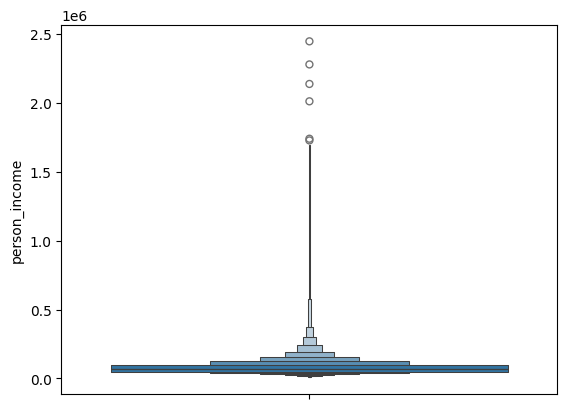

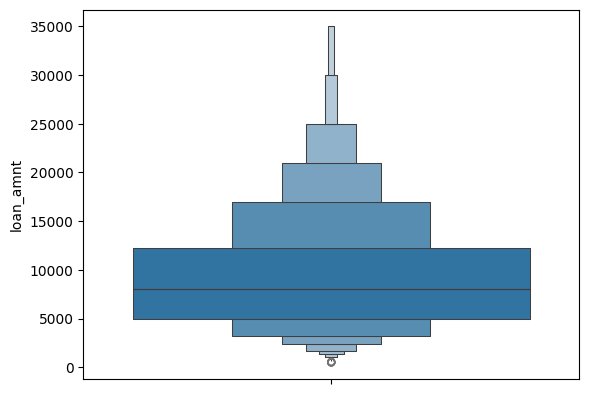

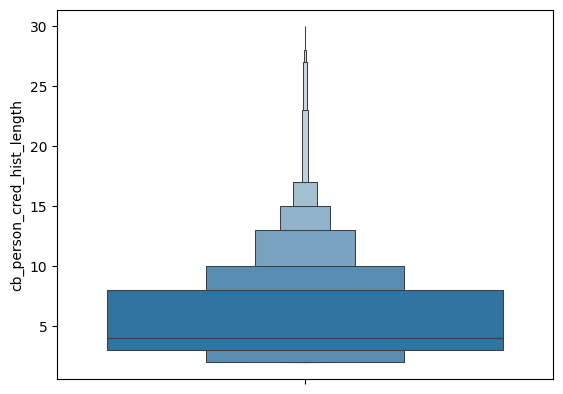

In [13]:
sns.boxenplot(data=df, y='person_income')
plt.show()
sns.boxenplot(data=df, y='loan_amnt')
plt.show()
sns.boxenplot(data=df, y='cb_person_cred_hist_length')
plt.show()

# Going to invistigate the [annual_income] more

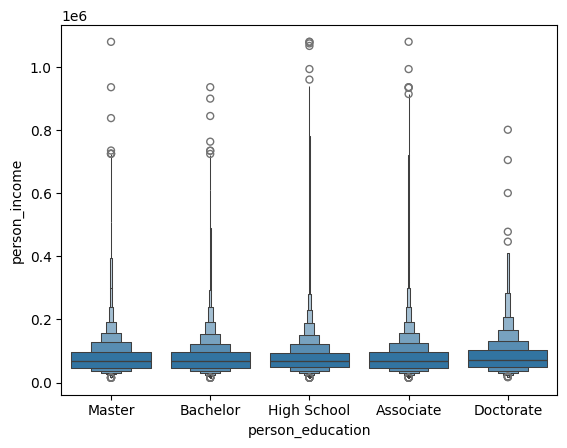

In [73]:
sns.boxenplot(data=df, y='person_income', x='person_education')
plt.show()


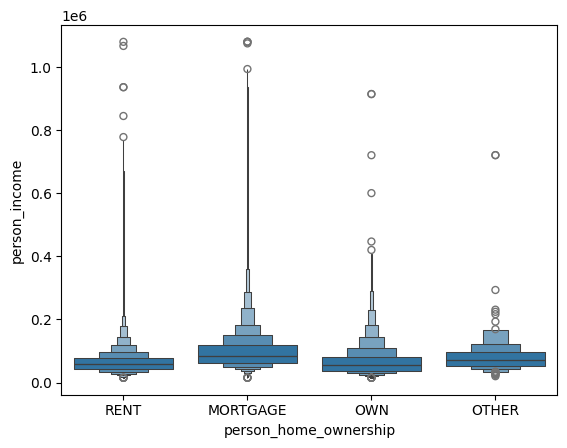

In [74]:
sns.boxenplot(data=df, y='person_income', x='person_home_ownership')
plt.show()

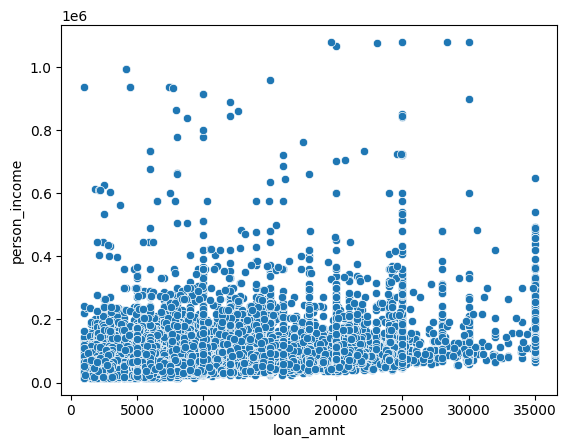

In [75]:
sns.scatterplot(data=df,  y='person_income', x='loan_amnt')
plt.show()

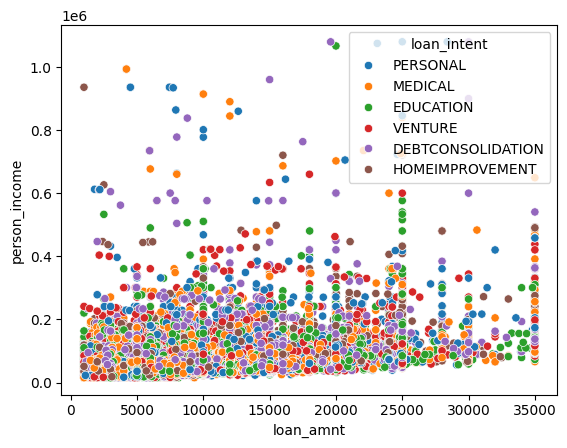

In [76]:
sns.scatterplot(data=df,  y='person_income', x='loan_amnt', hue='loan_intent')
plt.show()

[person_income] has a problem, so we have to know more about incomes in US.
1. It's clear now that there are wrong values in the dataset, as it's unnatureal for those who get annual income of more than 1M$ to loan less than 15K$

2.  Minimum income as 8000$ is definitely wrong, it could be the information of monthly income, because the average annual income in 2022 US for age +25 is more than 30,0000$.

In [77]:
df.drop(df[df['person_income'] < 15_000].index, inplace=True)
df.drop(df[(df['person_income'] > 1_000_000) & (df['loan_amnt'] < 15_000)].index, inplace=True)


In [78]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,44759.0,27.743091,5.877689,20.00,24.00,26.00,30.0,78.0
person_income,44759.0,79700.597735,55828.131783,15013.00,47649.00,67108.00,95980.0,1081139.0
person_emp_exp,44759.0,5.387542,5.893877,0.00,1.00,4.00,8.0,58.0
loan_amnt,44759.0,9618.972117,6310.004472,1000.00,5000.00,8000.00,12289.0,35000.0
loan_int_rate,44759.0,11.007429,2.981051,5.42,8.59,11.01,13.0,20.0
cb_person_cred_hist_length,44759.0,5.863670,3.866113,2.00,3.00,4.00,8.0,30.0
credit_score,44759.0,632.589535,50.380598,390.00,601.00,640.00,670.0,784.0
loan_status,44759.0,0.219509,0.413919,0.00,0.00,0.00,0.0,1.0


For [loan_amnt] column we will remove values less than 1000, because "Most banks, credit unions, and online lenders don't offer personal loans for less than $1,000" (Source)[https://www.investopedia.com/can-you-get-a-usd500-personal-loan-7852432]

In [79]:
df.drop(df[df['loan_amnt'] < 1_000].index, inplace=True)

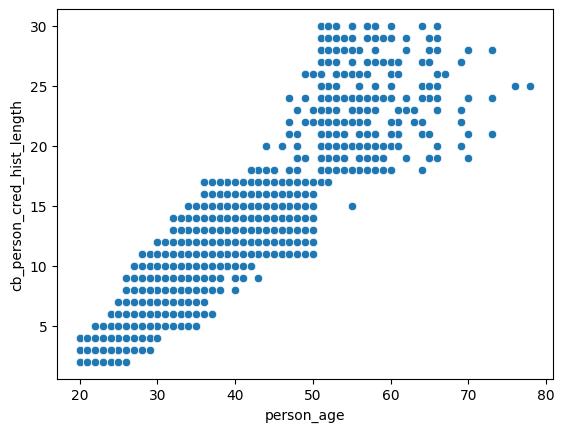

In [80]:
sns.scatterplot(data=df, x = 'person_age', y='cb_person_cred_hist_length')
plt.show()

For ['cb_person_cred_hist_length'], there are no problems.

Therd: [[loan_percent_income]] repeate 2 information, [loan_amnt] and [person_income], so we can look for removing one of these to reveale correlation.

In [81]:
df[['loan_percent_income', 'loan_amnt', 'person_income']].corr()

KeyError: "['loan_percent_income'] not in index"

We can see that [loan_percent_income] and [loan_amnt] are correlated ~(0.60), but it is not highly correlated, event the negative correlation with [person_income] is not that high, making a question of the correctness data in this column and give stronger reaon to remove it.

In [23]:
df.drop(columns=['loan_percent_income'], inplace=True)

Fourth: check for any correlation between the target variable [loan_status] and [[credit_score],[previous_loan_defaults_on_file], [loan_int_rate]]

In [24]:
data_correlation = df[['credit_score', 'previous_loan_defaults_on_file', 'loan_int_rate', 'loan_status']]

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() 

cat = ['previous_loan_defaults_on_file', 'loan_status']

for col in cat:
    data_correlation[col] = le.fit_transform(data_correlation[col])

C:\Users\fa-yy\AppData\Local\Temp\ipykernel_29100\30411137.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_correlation[col] = le.fit_transform(data_correlation[col])
C:\Users\fa-yy\AppData\Local\Temp\ipykernel_29100\30411137.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_correlation[col] = le.fit_transform(data_correlation[col])


In [26]:
data_correlation.corrwith(data_correlation['loan_status'])

credit_score                     -0.007070
previous_loan_defaults_on_file   -0.540675
loan_int_rate                     0.335061
loan_status                       1.000000
dtype: float64

[previous_loan_defaults_on_file] is correlated with the [loan_status] by -0.540675, this is consoderied as negative moderate correlation, so we can consider it as usefull information and keep it.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,44759.0,27.743091,5.877689,20.00,24.00,26.00,30.0,78.0
person_income,44759.0,79700.597735,55828.131783,15013.00,47649.00,67108.00,95980.0,1081139.0
person_emp_exp,44759.0,5.387542,5.893877,0.00,1.00,4.00,8.0,58.0
loan_amnt,44759.0,9618.972117,6310.004472,1000.00,5000.00,8000.00,12289.0,35000.0
loan_int_rate,44759.0,11.007429,2.981051,5.42,8.59,11.01,13.0,20.0
cb_person_cred_hist_length,44759.0,5.863670,3.866113,2.00,3.00,4.00,8.0,30.0
credit_score,44759.0,632.589535,50.380598,390.00,601.00,640.00,670.0,784.0
loan_status,44759.0,0.219509,0.413919,0.00,0.00,0.00,0.0,1.0


In [28]:
X = df.drop(columns='loan_status',axis=1)
y = df['loan_status']
y.value_counts()

loan_status
0    34934
1     9825
Name: count, dtype: int64

In [29]:
cat = df.select_dtypes("object").columns
cat

Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object')

In [30]:
#Create a column transformer to encode categorical columns

cat_transformer = ColumnTransformer([
    ('one_hot',OneHotEncoder(drop='first', handle_unknown='ignore'),['person_gender','loan_intent']),
    ('ordinal',OrdinalEncoder(categories=[[ "High School","Associate","Bachelor","Master","Doctorate"],['OTHER','MORTGAGE','RENT','OWN'],['No','Yes']],handle_unknown='error'),['person_education', 'person_home_ownership','previous_loan_defaults_on_file'])],
    remainder='passthrough')

scale_transformer = ColumnTransformer([('scaler', StandardScaler(), slice(0, None))])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
y_train.value_counts()

loan_status
0    27947
1     7860
Name: count, dtype: int64

We have imbalanced training data, so we need to experiment with multiple approaches and multiple models to 

In [33]:
scoring = {'f1': 'f1',
           'roc_auc': 'roc_auc',
           'precision': 'precision',
           'recall': 'recall'}

In [37]:
from imblearn.over_sampling import SMOTE


In [53]:

# I will include main changes in the run name
run_name = " LogisticRegression with SMOTE"


pipe = Pipeline([
    ("CategoricalFeatures", cat_transformer),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
#    ('undersampler', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ("Scaler", scale_transformer),
    ('clf', LogisticRegression())
])

scores = cross_validate(estimator=pipe,
                        X=X_train,
                        y=y_train,
                        cv=10, 
                        scoring=scoring,
                        n_jobs=-1)


In [54]:
f1_mean = scores.get('test_f1').mean()
roc_auc_mean = scores.get('test_roc_auc').mean()
precision_mean = scores.get('test_precision').mean()
recall_mean = scores.get('test_recall').mean()

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
    # Log parameters of the classifier in the pipeline
    mlflow.log_params(pipe.named_steps['clf'].get_params())
    
    # Log metrics
    mlflow.log_metric("f1_mean", f1_mean)
    mlflow.log_metric("roc_auc_mean", roc_auc_mean)
    mlflow.log_metric("precision_mean", precision_mean)
    mlflow.log_metric("recall_mean", recall_mean)

    # Log the pipeline model
    mlflow.sklearn.log_model(pipe, "model")


2025/01/23 23:59:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


![Results](artifacts\images\image.png)


We can see after comparing all the experiments that **RandomForestClassifier with SMOTE** gives the most robust performance, so we will test it.

In [83]:

pipe = Pipeline([
    ("CategoricalFeatures", cat_transformer),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ("Scaler", scale_transformer),
    ('clf', RandomForestClassifier())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6987
           1       0.83      0.79      0.81      1965

    accuracy                           0.92      8952
   macro avg       0.89      0.87      0.88      8952
weighted avg       0.92      0.92      0.92      8952



As we care about the two classes equally, this performance is very good.
so, we will register the model and use it.

In [84]:
import pickle

with open('artifacts\model\model_v1.pkl', 'wb') as f:
    pickle.dump(pipe, f)
